In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from numpy import argmax
from keras.preprocessing.image import img_to_array
from keras.models import load_model
from PIL import Image, ImageOps

print(tf.__version__)


2.8.0


In [2]:
mnist = tf.keras.datasets.mnist
(x_train, y_train), (x_test, y_test) = mnist.load_data()
print(x_train.shape)
x_train = tf.keras.utils.normalize(x_train, axis=1)
print(x_train.shape)
x_test = tf.keras.utils.normalize(x_test, axis=1)

model = tf.keras.models.Sequential()
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(128, activation=tf.nn.relu))
model.add(tf.keras.layers.Dense(128, activation=tf.nn.relu))
model.add(tf.keras.layers.Dense(128, activation=tf.nn.relu))
model.add(tf.keras.layers.Dense(10, activation=tf.nn.softmax))

model.compile(optimizer='adam',
             loss='sparse_categorical_crossentropy',
             metrics=['accuracy'])

model.fit(x_train, y_train, epochs=3)

(60000, 28, 28)
(60000, 28, 28)
Epoch 1/3
1875/1875 [==============================] - 6s 3ms/step - loss: 0.2502 - accuracy: 0.9238
Epoch 2/3
1875/1875 [==============================] - 5s 3ms/step - loss: 0.1031 - accuracy: 0.9678
Epoch 3/3
1875/1875 [==============================] - 5s 2ms/step - loss: 0.0712 - accuracy: 0.9776


In [3]:
val_loss, val_acc = model.evaluate(x_test, y_test)
print(val_loss, val_acc)

313/313 [==============================] - 1s 2ms/step - loss: 0.1003 - accuracy: 0.9695
0.10034933686256409 0.9695000052452087


In [4]:
# save model
model.save('digit_model.model')

# load the model saved
new_model = tf.keras.models.load_model('digit_model.model')

INFO:tensorflow:Assets written to: digit_model.model\assets


In [5]:
predictions = new_model.predict([x_test])

7


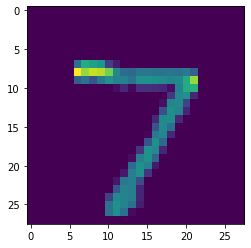

In [6]:
print(np.argmax(predictions[0]))
plt.imshow(x_test[0])
plt.show()

In [7]:
# load and prepare the image
def load_image(filename):
    # load the image
    img = ImageOps.grayscale(Image.open(filename))

    # reshape into a single sample with 1 channel
    img = np.resize(img, (28,28,1))

    # convert to array
    img = img_to_array(img)
    img = img.reshape(1, 28, 28)

    # prepare pixel data
    img = img.astype('float32')
    img = img / 255.0
    return img

Número 0 - Chance 0.00000%
Número 1 - Chance 0.00017%
Número 2 - Chance 99.99590%
Número 3 - Chance 0.00323%
Número 4 - Chance 0.00001%
Número 5 - Chance 0.00000%
Número 6 - Chance 0.00000%
Número 7 - Chance 0.00068%
Número 8 - Chance 0.00000%
Número 9 - Chance 0.00001%
O número da imagem é: 2


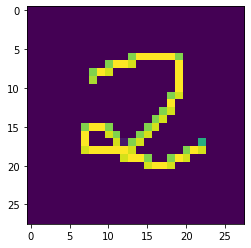

In [8]:
img = load_image('tests/img2.png')

predict = model.predict(img)
for ind, res in enumerate(predict[0]):
    print(f'Número {ind} - Chance {res * 100:.5f}%')
print('O número da imagem é:',argmax(predict))

plt.imshow(img[0])
plt.show()